Assignment on Graph Neural Networks in the course Advanced machine learning using neural networks (Chalmers and University of Gothenburg).

The objective is to train a GNN that works as a graph classifier on the provided data. The data comes from simulations of a 25 qubit quantum memory (surface code) with individual error rates of 5% per cycle of measurements (see assignment text for a little more detail). Since the data consists of graphs with varying number of nodes the way to implement the classifier is to make a graph embedding, i.e. a mapping of each graph to a vector of fixed size. This can then be used for classification. The typical structure would be Graph data-> Graph (convolution or other) layers -> Pooling -> Dense classifier.

For this data the classification accuracy of the standard graph algorithm based decoder (minimum weight perfect matching) is 0.983. It may be hard to reach this without an even larger dataset, but it can serve as a target. Anything above an accuracy of 0.95 is acceptable. (This means that the quantum memory has a lower failure rate than the individual qubits, which is set at 5% to generate the data.)


In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

Some suggested GNN layers, you're welcome to try other.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
import networkx as nx
from torch.nn import Linear
from torch_geometric.nn import global_mean_pool, GraphConv, GATConv, GCNConv

%config InlineBackend.figure_format = 'svg'

The following shows how to load the data if it's available in your Google drive


In [3]:
# #If the data is available in your Google drive:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
#It's a quite big dataset, so may take a few minutes
small = False

# only run if dataset is not loaded
if (small):
    dataset = torch.load('dataset/graph_data_decoding_2024_small.pt')
else:
    dataset = torch.load('dataset/graph_data_decoding_2024.pt')

Properties of the graphs


In [5]:
print('====================')
print(f'Number of graphs: {len(dataset)}')
print('=============================================================')
data = dataset[7]  # Get one data point.

print('Some properties of a graph in the dataset:')
print()

print(data)
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Number of node features: {data.num_node_features}')


Number of graphs: 1000000
Some properties of a graph in the dataset:

Data(x=[8, 4], edge_index=[2, 52], edge_attr=[52, 1], y=[1, 2])
Number of nodes: 8
Number of edges: 52
Average node degree: 6.50
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of node features: 4


Note that the label y, is given by a tensor with 2 elements, giving a binary representation of the predicted equivalence class.

- 00 <-> class I
- 10 <-> class X
- 01 <-> class Z
- 11 <-> class Y

The loss can either be constructed using two spearate classifiers, one for X and one for Z, or combined into one over all four classes. Either should work.


In [6]:
label=data.y
label_X=label[:,0]
label_Z=label[:,1]
print(label, label_X,label_Z)
#The data point dataset[20] is thus in class X

tensor([[0., 0.]]) tensor([0.]) tensor([0.])


In [7]:
# print a random data point
import numpy as np
for i in range(1):
    print("===========================")
    j = np.random.randint(0, len(dataset))
    data = dataset[j]
    print(j, data)
    print(data.x)
    print(data.edge_index)
    print(data.edge_attr)
    print(data.y)
    print(data.batch)

100703 Data(x=[2, 4], edge_index=[2, 2], edge_attr=[2, 1], y=[1, 2])
tensor([[1.0000, 0.0000, 0.4000, 0.4000],
        [1.0000, 0.0000, 0.8000, 0.4000]])
tensor([[0, 1],
        [1, 0]])
tensor([[0.2500],
        [0.2500]])
tensor([[0., 0.]])
None


The data consists of 4-dimensional feature vector per node, and each edge comes with a scalar weight.


In [8]:
edge_index = data.edge_index.t()
edge_index=edge_index.numpy()
feature=data.x.numpy()
edge=data.edge_attr.numpy()
print(edge_index)
print(edge)
print(feature)

[[0 1]
 [1 0]]
[[0.25]
 [0.25]]
[[1.  0.  0.4 0.4]
 [1.  0.  0.8 0.4]]


In [9]:
graph = dataset[7]
g = utils.to_networkx(graph, to_undirected=True)
positions = {}
label_positions = {}
node_labels = {}
edge_labels={}
x = graph.x
for i in range(x.shape[0]):
    positions[i] = np.array([x[i, 2], x[i, 3]])
    label_positions[i] = np.array([x[i, 2], x[i, 3]])
    node_labels[i] = np.array([x[i, 0], x[i, 1], x[i, 2], x[i, 3]])
for i in range(edge_index.shape[0]):
    edge_labels[(edge_index[i,0],edge_index[i,1])]=edge[i]

tensor([[0., 0.]])


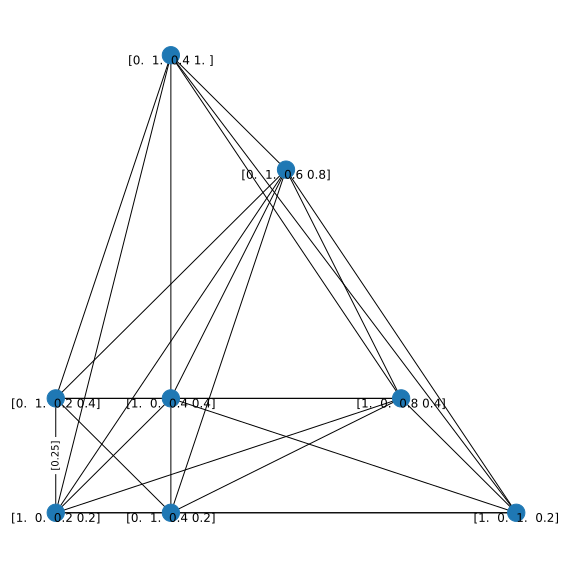

In [10]:
fig, ax = plt.subplots(figsize = (10, 10))
nx.draw_networkx(g, ax=ax, pos = positions, labels = node_labels, with_labels = False)
nx.draw_networkx_labels(g, ax=ax, pos = label_positions, labels = node_labels, verticalalignment= 'top')
nx.draw_networkx_edge_labels(g,ax=ax,  pos = positions, edge_labels=edge_labels)
ax.axis('off')
print(data.y)

In [11]:
# the output data comes in the format: tensor([[1., 0.]]) as an example
# if the tensor is 0,0 then the output value is 0 otherwise it is 1

# function to convert the output tensor to a scalar
def output_to_scalar(output):
    scalar = 0
    for i in range(output.shape[1]):
        scalar += output[0][i] * (2 ** i)
    scalar = int(scalar)

    # flip 1 and 2
    if scalar == 1:
        scalar = 2
    elif scalar == 2:
        scalar = 1

    return int(scalar)

In [12]:
for i in range(10):
    indx = np.random.randint(0, len(dataset))
    data = dataset[indx]
    scalar = output_to_scalar(data.y)
    print(f'Example {indx}: {data.y} \t {scalar}')

Example 798709: tensor([[0., 1.]]) 	 1
Example 706467: tensor([[1., 0.]]) 	 2
Example 635961: tensor([[0., 0.]]) 	 0
Example 84623: tensor([[1., 0.]]) 	 2
Example 437340: tensor([[0., 0.]]) 	 0
Example 762343: tensor([[0., 0.]]) 	 0
Example 979489: tensor([[0., 0.]]) 	 0
Example 504912: tensor([[0., 0.]]) 	 0
Example 84564: tensor([[0., 0.]]) 	 0
Example 96981: tensor([[1., 0.]]) 	 2


In [13]:
# transform the dataset to a scalar label
for data in dataset:
    data.y = output_to_scalar(data.y)

# print a sample to check if transformation was successful
for i in range(10):
    data = dataset[i]
    print(data.y)

0
0
2
0
0
0
1
0
0
1


In [14]:
# split the dataset into test and validation:
num_samples = len(dataset)
train_data = dataset[int(.05 * num_samples ) :] # 95% train
test_data = dataset[: int(.05 * num_samples )] # 5% test
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)

In [15]:
# # save the train dataset as a .pt file
# torch.save(test_data, 'dataset/graph_data_decoding_2024_small.pt')

Construct you network. Train and test.


In [20]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool

# Create a GCN model for the graph classification task

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=16):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        # self.conv1 = GCNConv(dataset[0].x.shape[1], hidden_channels)
        # self.conv2 = GCNConv(hidden_channels, hidden_channels)
        # self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv1 = GraphConv(dataset[0].x.shape[1], hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        # self.conv4 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 4)    # we want to classify the four cases (00, 01, 10, 11 -> I, X, Z, Y)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        # x = x.relu()
        # x = self.conv4(x, edge_index)

        x = global_mean_pool(x, data.batch)

        # Drop out layer
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.lin(x)

        return x

hidden_channels = 32
# train the model
model = GCN(hidden_channels=hidden_channels)

print(model)

GCN(
  (conv1): GraphConv(4, 16)
  (conv2): GraphConv(16, 16)
  (conv3): GraphConv(16, 16)
  (conv4): GraphConv(16, 16)
  (lin): Linear(in_features=16, out_features=4, bias=True)
)


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

import time

def trainModel():
    model.train()

    for data in train_loader:
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def testModel(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data)
        pred = out.argmax(dim=1)

        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)


In [22]:
training_tracker = []
testing_tracker = []

numberOfEpochs = 10

In [23]:
from tqdm import trange
for epoch in trange(numberOfEpochs):
    starttime = time.time()
    trainModel()
    training_accuracy = testModel(train_loader)
    testing_accuracy = testModel(test_loader)
    training_tracker.append(training_accuracy)
    testing_tracker.append(testing_accuracy)
    print(f'Epoch {epoch}, Training Accuracy: {training_accuracy:.3f}, Testing Accuracy: {testing_accuracy:.3f}')
    endtime = time.time()
    print(f"Time taken for epoch {epoch} is {endtime - starttime:.3f} seconds")


 10%|█         | 1/10 [01:19<11:57, 79.70s/it]

Epoch 0, Training Accuracy: 0.916, Testing Accuracy: 0.916
Time taken for epoch 0 is 79.701 seconds


 20%|██        | 2/10 [02:39<10:39, 79.93s/it]

Epoch 1, Training Accuracy: 0.923, Testing Accuracy: 0.922
Time taken for epoch 1 is 80.086 seconds


 30%|███       | 3/10 [04:00<09:21, 80.18s/it]

Epoch 2, Training Accuracy: 0.937, Testing Accuracy: 0.937
Time taken for epoch 2 is 80.482 seconds


 40%|████      | 4/10 [05:47<09:04, 90.77s/it]

Epoch 3, Training Accuracy: 0.941, Testing Accuracy: 0.942
Time taken for epoch 3 is 107.004 seconds


 50%|█████     | 5/10 [07:28<07:53, 94.70s/it]

Epoch 4, Training Accuracy: 0.943, Testing Accuracy: 0.944
Time taken for epoch 4 is 101.661 seconds


 60%|██████    | 6/10 [09:06<06:22, 95.51s/it]

Epoch 5, Training Accuracy: 0.942, Testing Accuracy: 0.944
Time taken for epoch 5 is 97.078 seconds


 60%|██████    | 6/10 [09:17<06:11, 92.97s/it]


KeyboardInterrupt: 

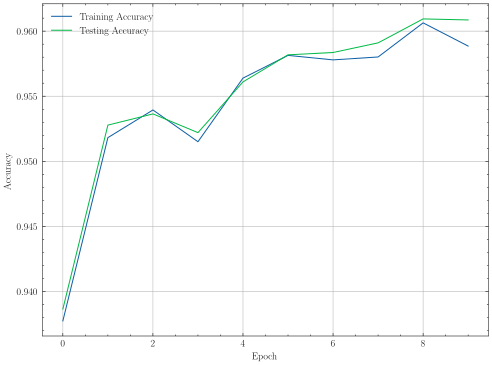

In [ ]:
import scienceplots
path = 'modeldata/'
suffix = str(hidden_channels)
plt.style.use('science')

# plot the training and testing loss
plt.figure(figsize=(8, 6))
plt.plot(training_tracker, label='Training Accuracy')
plt.plot(testing_tracker, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('minor')
plt.savefig(path +'accuracy_' + suffix + '.png')
plt.show()

In [ ]:
# save the model
torch.save(model.state_dict(), path+'model_' + suffix+'.pt')

# save the trackers
np.save(path+'training_tracker_' + suffix + '.npy', training_tracker)
np.save(path+'testing_tracker_' + suffix + '.npy', testing_tracker)

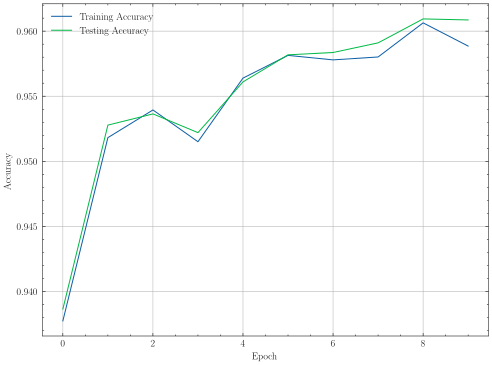

In [ ]:
# load the model
loadedModel = torch.load(path+'model_'+suffix+'.pt')

# load the trackers
training_tracker = np.load(path+'training_tracker_' + suffix +'.npy')
testing_tracker = np.load(path+'testing_tracker_' + suffix +'.npy')

# plot the training and testing loss
plt.figure(figsize=(8, 6))
plt.plot(training_tracker, label='Training Accuracy')
plt.plot(testing_tracker, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid('minor')
plt.show()